# Intra-frame offset analysis

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# External packages
import os
import jupyter_slack
import datetime
from scipy.optimize import curve_fit

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.indexers import FrameIndexer

# Root directory for output figures
figsdir = get_data_root(kind=DataRoot.FIG)  
logger.info(f'output figures directory: "{figsdir}"')

# Get time stamp from notebook completion
tstamp_start = datetime.datetime.now()

# Figures dictionary
figs = {}

 2025/07/04 15:24:42: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs"


### Input datasets and main processing parameters

In [4]:
analysis_type = 'offset'  # Analysis type
mouseline = 'sst'
layer = None  # cortical layer
slack_notify = False

### Derived parameters

In [5]:
refcolor = Palette.LINE[mouseline]

### Load and organize data

In [6]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = [f for f in os.listdir(datadir) if f.endswith('.h5')]

# For each input file
trialagg_dFF, info_table = {}, {}
for fname in datafiles:
    # Parse dataset ID from file name
    dataset_ID = os.path.splitext(fname)[0]
    # Load dFF data and info table
    dFF, table = load_rowavg_dataset(os.path.join(datadir, fname))
    # If no baseline data, skip this dataset
    if not any(table[Label.P] == 0.):
        logger.warning(f'no data for P = 0 in {dataset_ID} -> skipping')
        continue
    # Restrict data to non-duplicated runs
    iruns = get_param_code(table).drop_duplicates(keep='first').index.values
    table = table.loc[iruns]
    dFF = dFF.loc[pd.IndexSlice[iruns, :, :]]
    # Average dFF data across trials, and add to dictionary
    logger.info('computing trial-average dFF profiles')
    info_table[dataset_ID] = table
    trialagg_dFF[dataset_ID] = dFF.groupby([Label.RUN, Label.FRAMEROW]).mean()

# Assemble trial-average dFF profiles into multi-indexed pandas Series
logger.info(f'assembling {len(trialagg_dFF)} datasets into single multi-indexed series')
trialagg_dFF = pd.concat(trialagg_dFF, axis=0, names=[Label.DATASET])

# Assemble info table into single DataFrame
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET])
info_table = add_intensity_to_table(info_table, precision=2)

# Extract PRF, duration, and number of pulses from info table
PRF = get_singleton(info_table, Label.PRF)
dur = get_singleton(info_table, Label.DUR)
npulses = int(dur * PRF)

# Create a mapping from ISPTA to DC
ispta_DC_map = info_table.groupby(Label.ISPTA).first()[Label.DC]

# Extract stimulus onset time from info table, and construct FrameIndexer
fps = get_singleton(info_table, Label.FPS)
lpf = get_singleton(info_table, Label.LPF)
nframes_per_trial = get_singleton(info_table, Label.NPERTRIAL)
tref = get_stim_onset_time(mouseline)
fidx = FrameIndexer.from_time(tref, TPRE, TPOST, 1 / fps, npertrial=nframes_per_trial).resample(lpf)

# Subtract pre-stimulus baseline levels for each dataset and run
logger.info('subtracting pre-stimulus baseline levels')
gby = [Label.DATASET, Label.RUN]
def subtract_baseline(y):
    y0 = y.droplevel(gby).loc[:fidx.iref].median()
    return y - y0
trialagg_dFF = trialagg_dFF.groupby([Label.DATASET, Label.RUN]).transform(subtract_baseline)

# Add relevant columns from info table to trial-aggregated dFF
exp_keys = [Label.P, Label.DC, Label.ISPPA, Label.ISPTA]
trialagg_dFF = free_expand_and_add(info_table[exp_keys], trialagg_dFF.to_frame())

# Remove data for DC = 1%
logger.info('removing data for DC = 1%')
trialagg_dFF = trialagg_dFF[trialagg_dFF[Label.DC] != 1.0]

# Add time vector to trial-aggregated dFF
add_time_to_table(trialagg_dFF, fidx=fidx, fps=fps * lpf)

# Add row index column to trialagg_dFF
logger.info('adding row index column')
trialagg_dFF['row'] = trialagg_dFF.index.get_level_values(Label.FRAMEROW) % lpf

# Remove "run" and add ISPTA to index
trialagg_dFF = (trialagg_dFF
    .droplevel(Label.RUN)
    .set_index(Label.ISPTA, append=True)
    .swaplevel(1, 2)
    .sort_index()
)

trialagg_dFF

 2025/07/04 15:26:51: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/offset/sst


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tlemaire/Documents/data/usnm/rowavg/offset/sst'

### Define plot parameters

In [5]:
# Restrict time bounds for plotting 
tbounds = {
    'default': (-1, 5),  # Default time bounds
    'zoomed': (-0.1, 0.3)  # Time bounds around stimulus
}

# Common plot parameters
pltkwargs = {
    'ispta_DC_map': ispta_DC_map,
    'stimdur': dur,
    'stimPRF': PRF,
    'fps': fps,
    'stimdelay': STIM_TRIG_DELAY,
}

### Plot trial-aggregated dFF vs ISPTA, across datasets (default and zoom-in around stimulus)

 2025/07/04 14:30:42: plotting ΔF/F0 time-varying profile per ISPTA between -1 and 5 s
 2025/07/04 14:31:04: plotting ΔF/F0 time-varying profile per ISPTA between -0.1 and 0.3 s


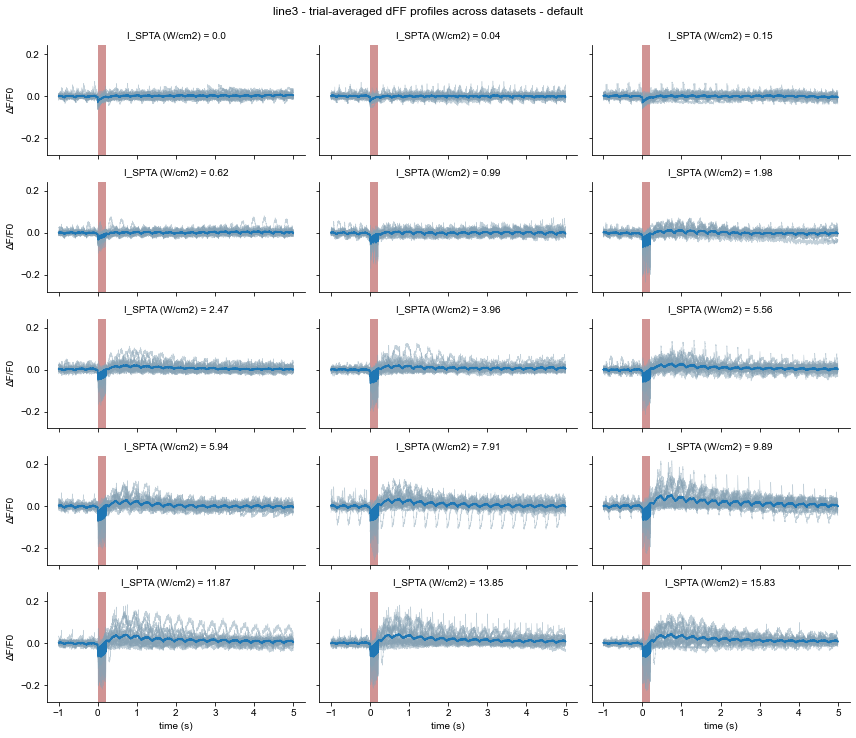

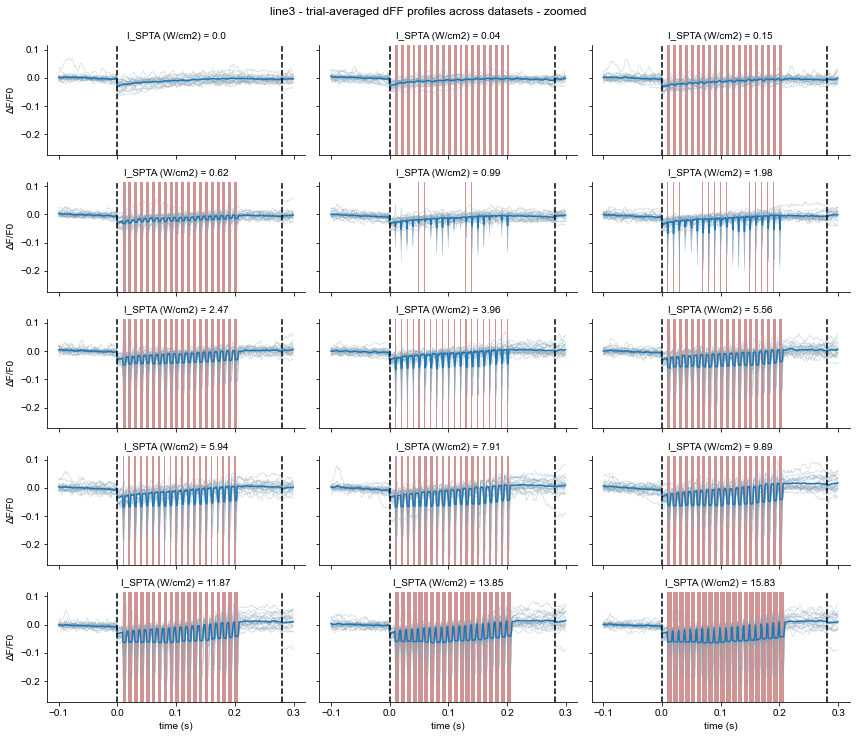

In [6]:
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles across datasets - {k}'
    figs[title] = plot_profile_vs_ispta(trialagg_dFF.copy(), tbounds=v, units=Label.DATASET, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

### Show only cross-dataset average

 2025/07/04 14:31:11: computing cross-dataset aggregates
 2025/07/04 14:31:12: plotting ΔF/F0 time-varying profile per ISPTA between -1 and 5 s
 2025/07/04 14:31:13: computing cross-dataset aggregates
 2025/07/04 14:31:14: plotting ΔF/F0 time-varying profile per ISPTA between -0.1 and 0.3 s


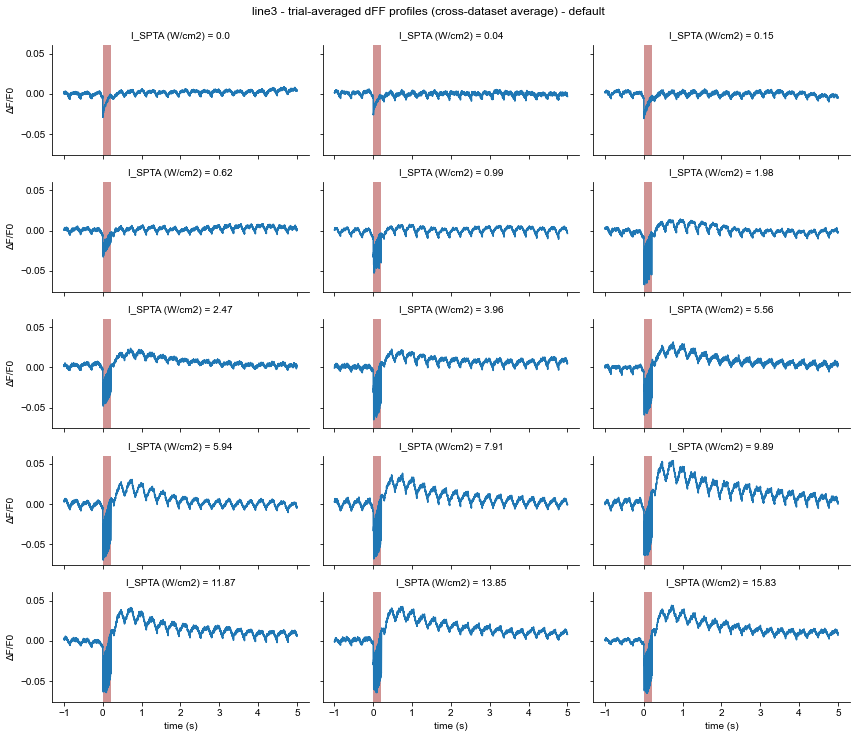

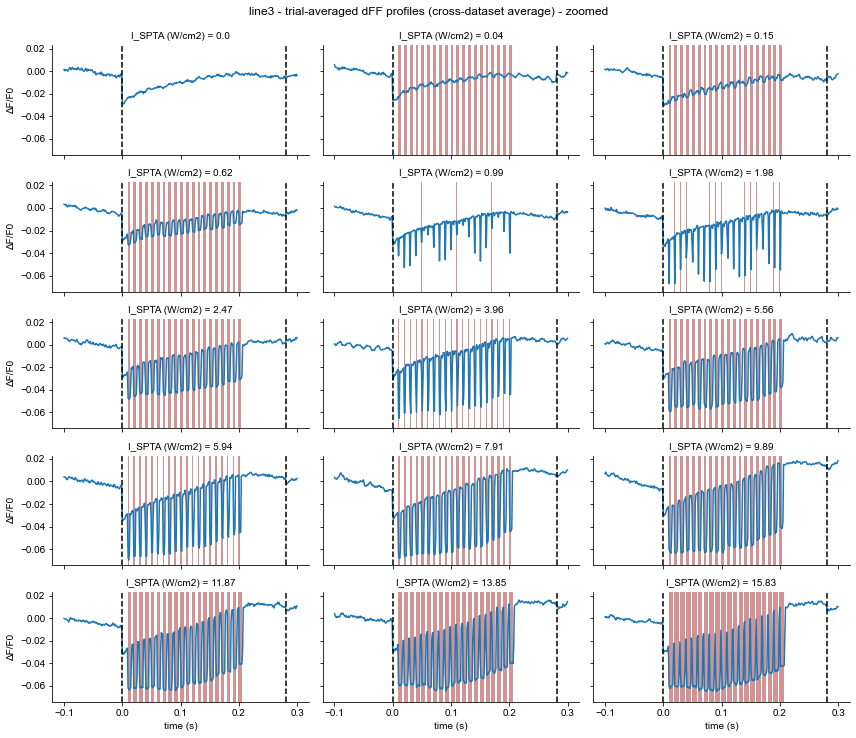

In [7]:
# Define function to aggregate across datasets
def aggregate_across_datasets(data):
    '''
    Aggregate across datasets by averaging dFF columns and 
    keeping first values for other columns.
    '''
    logger.info('computing cross-dataset aggregates')
    agg_funcs = {k: 'mean' if Label.DFF in k else 'first' for k in data.columns}
    return data.groupby([Label.ISPTA, Label.FRAMEROW]).agg(agg_funcs)

# Plot cross-dataset average trial-averaged dFF
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles (cross-dataset average) - {k}'
    figs[title] = plot_profile_vs_ispta(aggregate_across_datasets(trialagg_dFF), tbounds=v, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

## Deconstruct dFF profile during stimulus

mixture of:
- 3.5 Hz oscillation, coming from the line scanning through FOV (can be predicted from previous frames?)
- trigger-induced initial DC dip + exponential decay recovery, probably coming from hardware/acquisition artifacts (also present at P = 0)
- DC offset during each US pulse in the pulse train, with full recovery between pulses

algorithm to deconstruct dFF profile during stimulus
1. remove 3.5 Hz oscillation by subtracting profile from previous frame(s)
2. remove trigger-induced initial DC dip + exponential decay recovery, fitted to profile at I = 0
3. quantify DC offset during each US pulse, stationarity within and across pulses, recoveries between pulses, etc.

### Remove slow response trend 

 2025/07/04 14:31:18: interpolating dFF values to extract slow response trend
 2025/07/04 14:31:21: subtracting interpolated response trend from original profile
 2025/07/04 14:31:21: computing cross-dataset aggregates
 2025/07/04 14:31:21: plotting ['ΔF/F0', 'ΔF/F0 response trend', 'response corrected ΔF/F0'] time-varying profile per ISPTA between -1 and 5 s
 2025/07/04 14:31:25: computing cross-dataset aggregates
 2025/07/04 14:31:25: plotting ['ΔF/F0', 'ΔF/F0 response trend', 'response corrected ΔF/F0'] time-varying profile per ISPTA between -0.1 and 0.3 s


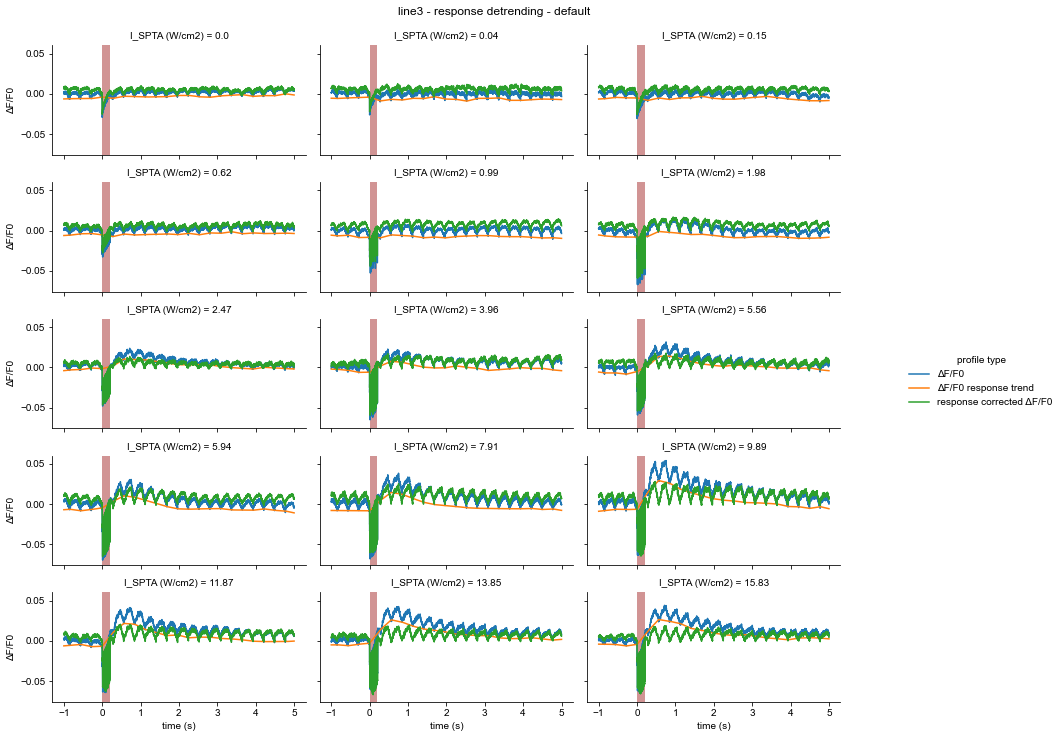

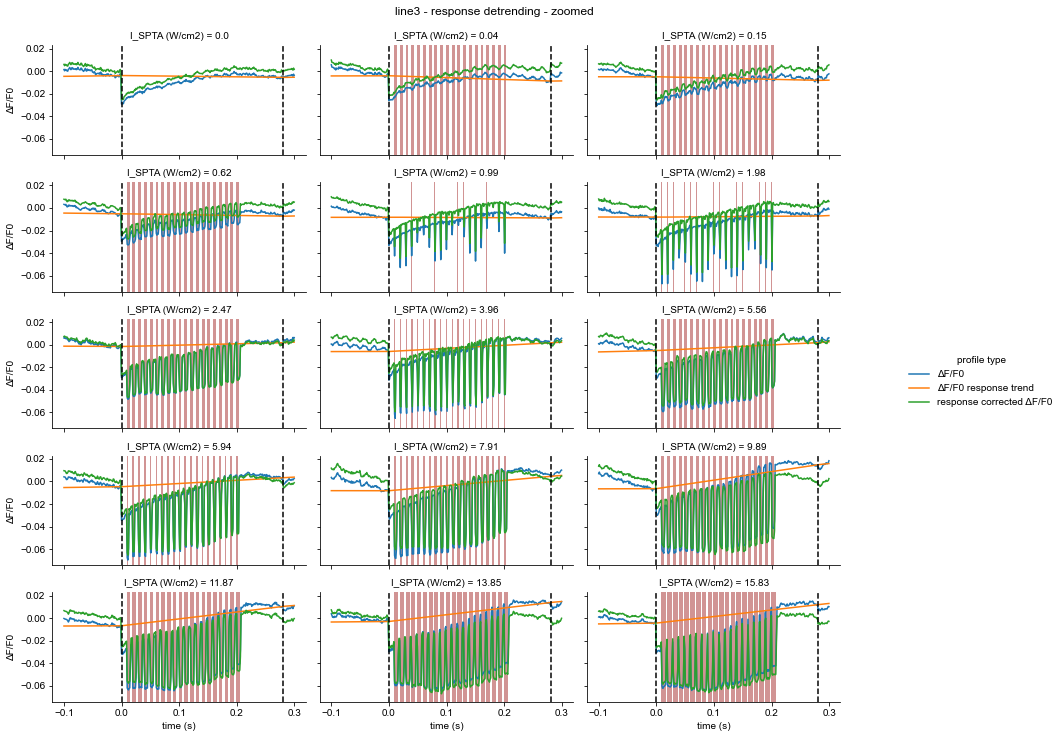

In [8]:
# Interpolate dFF values between the last row of each frame to extract "slow response trend"
logger.info('interpolating dFF values to extract slow response trend')
trialagg_dFF['row'] = trialagg_dFF.index.get_level_values(Label.FRAMEROW) % lpf
resp_ykey = f'{Label.DFF} response trend'
trialagg_dFF[resp_ykey] = trialagg_dFF[Label.DFF].copy()
trialagg_dFF.loc[trialagg_dFF['row'] != (lpf - 1), resp_ykey] = np.nan
gby = [Label.DATASET, Label.ISPTA]
trialagg_dFF[resp_ykey] = (
    trialagg_dFF
    .groupby(gby)
    [resp_ykey]
    .apply(lambda x: x.droplevel(gby).interpolate(method='linear'))
)

# Subtract interpolated response trend from original profile
logger.info('subtracting interpolated response trend from original profile')
resp_corrected_ykey = f'response corrected {Label.DFF}'
trialagg_dFF[resp_corrected_ykey] = trialagg_dFF[Label.DFF] - trialagg_dFF[resp_ykey]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - response detrending - {k}'
    figs[title] = plot_profile_vs_ispta(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[Label.DFF, resp_ykey, resp_corrected_ykey],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

### Remove trigger-induced trend (using P = 0 profile as reference)

 2025/07/04 14:31:35: computing cross-dataset aggregates
 2025/07/04 14:31:36: plotting ['response corrected ΔF/F0', 'trigger-fitted response corrected ΔF/F0', 'trigger-corrected response corrected ΔF/F0'] time-varying profile per ISPTA between -0.1 and 0.3 s


Text(0.5, 1.02, 'line3 - trigger correction')

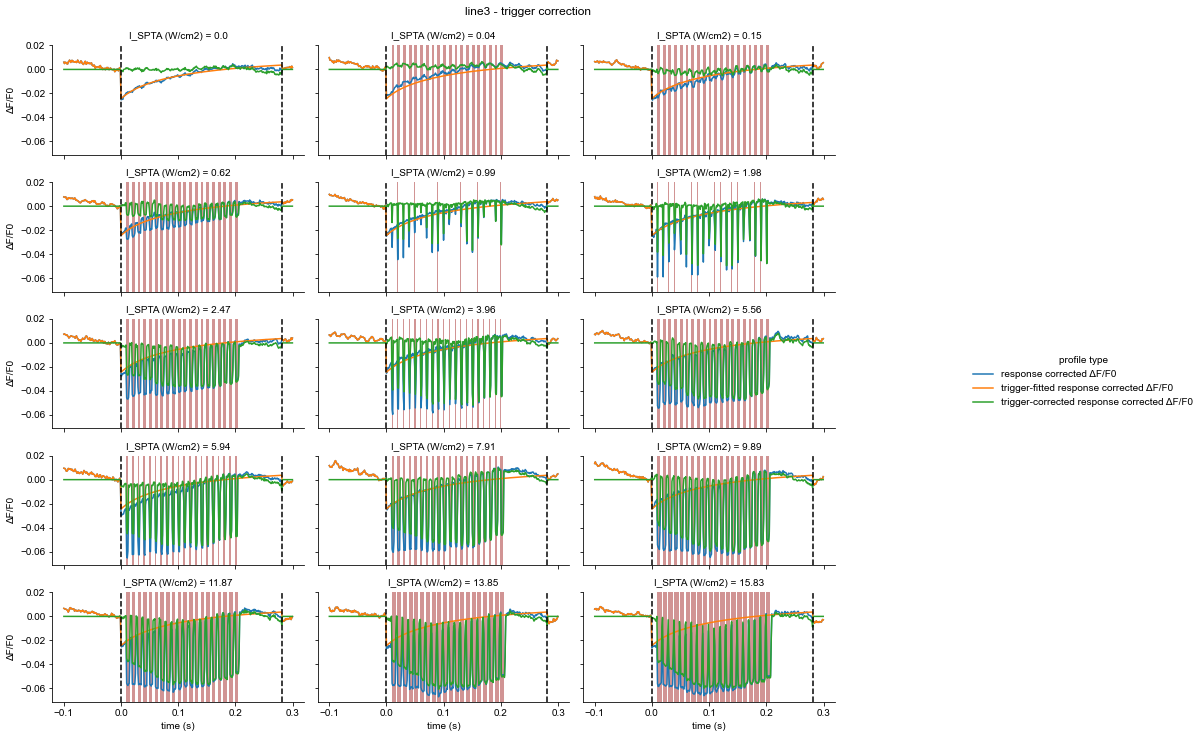

In [9]:
# Determine correction bounds (in both time and framerow index)
correction_tbounds = np.array([0, 1 / fps]) #dur + STIM_TRIG_DELAY])
correction_ibounds = np.round(correction_tbounds * fps * lpf).astype(int) + fidx.iref

# Define exponential decay function aligned at zero
def myfitfunc(x, H, A, tau):
    return expdecay(x, H, A, tau, 0)

# Define function to fit expdecay to profile
def fit_to_profile(y):
    x = np.arange(y.size)
    popt, _ = curve_fit(
        myfitfunc,
        x,
        y,
        p0=(-1, -1, 1e2),
    )
    return myfitfunc(x, *popt)

# Define function to fit expdecay on reference profile at I = 0 within correction window
def fit_to_reference_profile(y):
    y = y.droplevel(Label.DATASET)
    yref = y.loc[pd.IndexSlice[0, correction_ibounds[0]:correction_ibounds[1]]]
    yfit = fit_to_profile(yref.values)
    return pd.Series(yfit, index=yref.index)

# Fit exponential decay to reference profiles at I = 0 within correction window
yfits = (trialagg_dFF
    .groupby(Label.DATASET)
    [resp_corrected_ykey]
    .apply(fit_to_reference_profile)
    .rename('yref_fit')
)

# Define function to create new series with fitted reference profiles within correction window
def replace_by_fit(y):
    dataset_id = y.index[0][0]
    y = y.droplevel([Label.DATASET, Label.ISPTA])
    y.loc[correction_ibounds[0]:correction_ibounds[1]] = yfits.loc[dataset_id].values
    return y.values

# Apply to trialagg_dFF
trigger_fitted_ykey = f'trigger-fitted {resp_corrected_ykey}'
trialagg_dFF[trigger_fitted_ykey] = (trialagg_dFF
    .groupby([Label.DATASET, Label.ISPTA])
    [resp_corrected_ykey]
    .transform(replace_by_fit)
)

# Subtract fitted reference profile from each ISPTA profile within correction bounds
trigger_corrected_ykey = f'trigger-corrected {resp_corrected_ykey}'
trialagg_dFF[trigger_corrected_ykey] = trialagg_dFF[resp_corrected_ykey] - trialagg_dFF[trigger_fitted_ykey]

# Plot (only zoomed bounds)
title = f'{mouseline} - trigger correction'
figs[title] = plot_profile_vs_ispta(
    aggregate_across_datasets(trialagg_dFF),
    ykey=[resp_corrected_ykey, trigger_fitted_ykey, trigger_corrected_ykey],
    tbounds=tbounds['zoomed'], **pltkwargs
)
figs[title].suptitle(title, y=1.02)

### Plot final corrected profiles around stimulus window

 2025/07/04 14:31:41: computing cross-dataset aggregates
 2025/07/04 14:31:42: plotting trigger-corrected response corrected ΔF/F0 time-varying profile per ISPTA between -0.1 and 0.3 s


Text(0.5, 1.02, 'line3 - response detrended, trigger-corrected dFF')

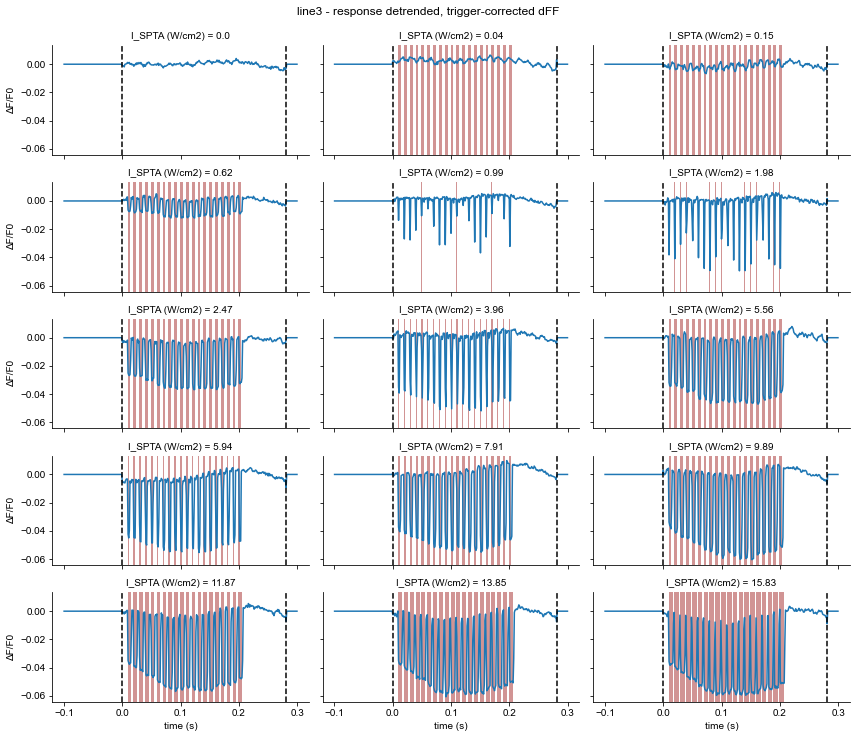

In [10]:
# Plot corrected signal around stimulus
title = f'{mouseline} - response detrended, trigger-corrected dFF'
figs[title] = plot_profile_vs_ispta(
    aggregate_across_datasets(trialagg_dFF),
    ykey=trigger_corrected_ykey,
    tbounds=tbounds['zoomed'],
    **pltkwargs
)
figs[title].suptitle(title, y=1.02)

### Inspect "within-pulse" trends

 2025/07/04 14:31:45: computing pulse index and relative time w.r.t pulse onset
 2025/07/04 14:31:45: computing cross-dataset aggregates


Text(0.5, 1.02, 'line3 - single pulse dFF')

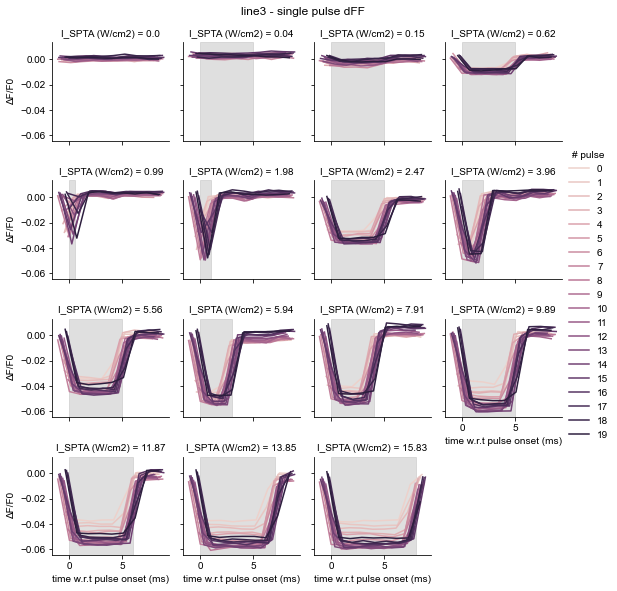

In [11]:
# Extract profile during stim window
stim_tbounds = np.array([STIM_TRIG_DELAY, STIM_TRIG_DELAY + dur])
stim_ibounds = np.ceil(stim_tbounds * fps * lpf).astype(int) + fidx.iref
stim_trialagg_dFF = trialagg_dFF.loc[pd.IndexSlice[:, :, stim_ibounds[0]:stim_ibounds[1] - 1], :].copy()

# Compute pulse index and relative time w.r.t pulse onset
logger.info('computing pulse index and relative time w.r.t pulse onset')
tvec = stim_trialagg_dFF[Label.TIME].values - stim_tbounds[0]
ipulse_key = '# pulse'
stim_trialagg_dFF[ipulse_key] = (tvec // (1 / PRF)).astype(int)
reltime_key = 'time w.r.t pulse onset (ms)'
stim_trialagg_dFF[reltime_key] = ((tvec % (1 / PRF)) - 1 / (fps * lpf)) * 1e3  # convert to time in ms

# Plot "single pulse" dFF profiles
g = sns.relplot(
    kind='line',
    data=aggregate_across_datasets(stim_trialagg_dFF),
    x=reltime_key,
    y=trigger_corrected_ykey,
    hue=ipulse_key,
    col=Label.ISPTA,
    col_wrap=4,
    height=2,
    legend='full',
)
g.set_axis_labels(reltime_key, Label.DFF)

# Add shaded areas for pulses
for ispta, ax in g.axes_dict.items():
    if ispta > 0:
        DC = ispta_DC_map.loc[ispta]
        PD = (DC * 1e-2) / PRF * 1e3  # ms
        tpulse = np.array([0, PD])
        ax.axvspan(*tpulse, color='silver', alpha=0.5)  # shaded area for pulse duration

title = f'{mouseline} - single pulse dFF'
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Quantify pulse-evoked dFF dip and its dependence on parameters and pulse index

 2025/07/04 15:21:02: computing pulse-evoked dFF dip
 2025/07/04 15:21:04: extracting "noise dip" at I = 0
 2025/07/04 15:21:04: plotting average pulse-evoked dFF dip vs P, ISPPA and DC
 2025/07/04 15:21:04: computing relative dip per pulse w.r.t first one
 2025/07/04 15:21:04: plotting relative change in pulse-evoked dFF dip


Text(0.5, 1.02, 'line3 - relative change in pulse-evoked dFF dip')

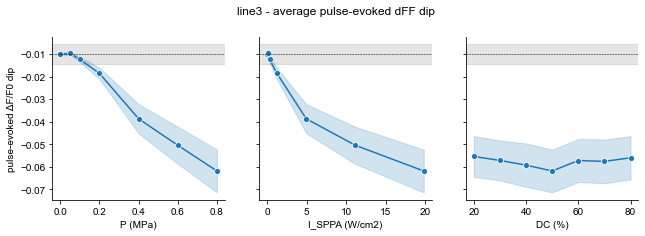

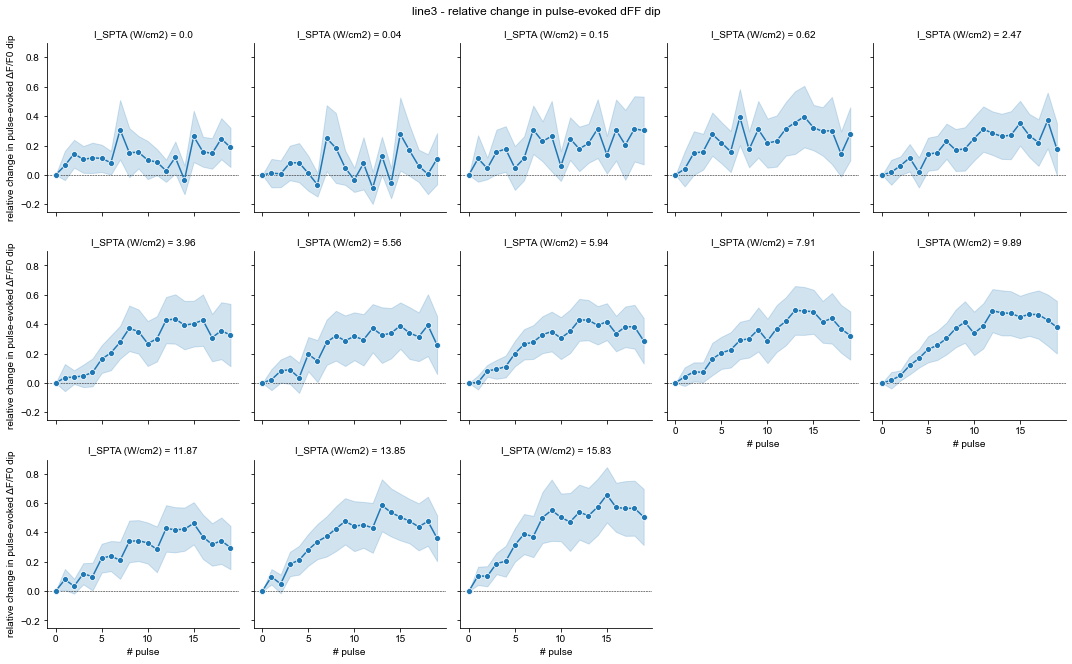

In [66]:
# Compute pulse-evoked dFF dip, along with P, DC, ISPPA, and ISPTA
logger.info('computing pulse-evoked dFF dip')
dip_ykey = f'pulse-evoked {Label.DFF} dip'
pulse_stats = (
    stim_trialagg_dFF
    .groupby([Label.DATASET, Label.ISPTA, ipulse_key])
    .agg({
        trigger_corrected_ykey: lambda x: -np.ptp(x),
        Label.P: 'first',
        Label.DC: 'first',
        Label.ISPPA: 'first',
    })
    .rename(columns={trigger_corrected_ykey: dip_ykey})
)

# Extract "noise dip" at I = 0
logger.info('extracting "noise dip" at I = 0')
noisedip = pulse_stats[dip_ykey].xs(0, level=Label.ISPTA)

# Restrict to DC >= 20% to avoid sub-sampled dips at low DCs
pulse_stats = pulse_stats[pulse_stats[Label.DC] >= 20.]

# Average across pulses for each ISPTA and dataset
pulseavg_stats = (
    pulse_stats
    .groupby([Label.DATASET, Label.ISPTA])
    .mean()
)

# Plot average pulse-evoked dip vs P, ISPPA and DC
logger.info('plotting average pulse-evoked dFF dip vs P, ISPPA and DC')
title = f'{mouseline} - average pulse-evoked dFF dip'
xkeys = [Label.P, Label.ISPPA, Label.DC]
figs[title], axes = plt.subplots(1, len(xkeys), figsize=(3.5 * len(xkeys), 3), sharey=True)
figs[title].suptitle(title, y=1.02)
for ax, xkey in zip(axes, xkeys):
    if xkey == Label.DC:
        pltdata = pulseavg_stats[pulseavg_stats[Label.P] == P_REF] 
    else:
        pltdata = pulseavg_stats[pulseavg_stats[Label.DC] == DC_REF]
    for kwargs in [
            # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
            dict(marker='o', errorbar='se')
        ]:
        sns.lineplot(
            ax=ax,
            data=pltdata,
            x=xkey,
            y=dip_ykey,
            color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
            legend=ax is axes[-1],
            **kwargs,
        )
    sns.despine(ax=ax)
    ax.axhline(noisedip.mean(), color='k', linestyle='--', linewidth=0.5, label='noise dip')
    ax.axhspan(noisedip.mean() - noisedip.std(), noisedip.mean() + noisedip.std(), color='k', alpha=0.1)

# Compute relative dip per pulse w.r.t first one, for each ISPTA and dataset
logger.info('computing relative dip per pulse w.r.t first one')
rel_dip_ykey = f'relative change in {dip_ykey}'
refdips = pulse_stats.loc[pd.IndexSlice[:, :, 0], dip_ykey].droplevel(ipulse_key)
pulse_stats[rel_dip_ykey] = (pulse_stats[dip_ykey] - refdips) / refdips

# Plot relative dip per pulse w.r.t first one, for each ISPTA and dataset
logger.info('plotting relative change in pulse-evoked dFF dip')
title = f'{mouseline} - relative change in pulse-evoked dFF dip'
g = sns.FacetGrid(
    data=pulse_stats.reset_index(),
    col=Label.ISPTA,
    col_wrap=5,
    height=3,
)
for ax in g.axes_dict.values():
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
for kwargs in [
        # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
        dict(marker='o', errorbar='se')
    ]:
    g.map_dataframe(
        sns.lineplot,
        x=ipulse_key,
        y=rel_dip_ykey,
        color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
        **kwargs
    )
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Save figures

In [ ]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=f'intraframe_{mouseline}_{analysis_type}_analysis')

 2025/07/04 15:22:47: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2025.07.04/figs_line3_intrapulse_analysis.pdf:


100%|██████████| 11/11 [00:15<00:00,  1.45s/it]


### Notify upon completion

In [14]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'intra-pulse analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/07/04 14:32:07: intra-pulse analysis notebook completed in 0:02:07.421884 s
